## Simple ensemble model with LeNet5 structure
#### with basic CNN structure LeNet5, let's make a super simple version of ensemble
I refered to this (https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import copy
import tqdm

%matplotlib inline

In [2]:
# make train & test dataset
class FashionMNIST(Dataset):
    def __init__(self, file, dir, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(os.path.join(dir, file))
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img, label
    
# aply transforms to return img as tensor type
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_path = '../input'
train_file = 'fashion-mnist_train.csv'
test_path = '../input'
test_file = 'fashion-mnist_test.csv'
train_dataset = FashionMNIST(train_file, train_path, transform = train_transform)
test_dataset = FashionMNIST(test_file, test_path, transform = test_transform)

# number of classes : 10
num_classes = len(set(train_dataset.labels))

In [3]:
# make dataloader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers=4)

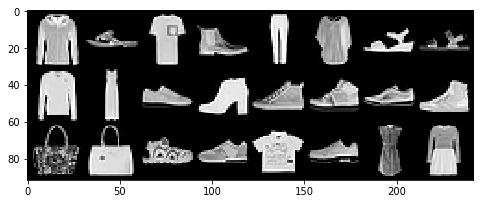

In [4]:
# check data loader works well
samples, labels = iter(train_loader).next()
plt.figure(figsize=(8,16))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

### The simple structure of LeNet5
#### 2 Conv layers and 2 FC layers
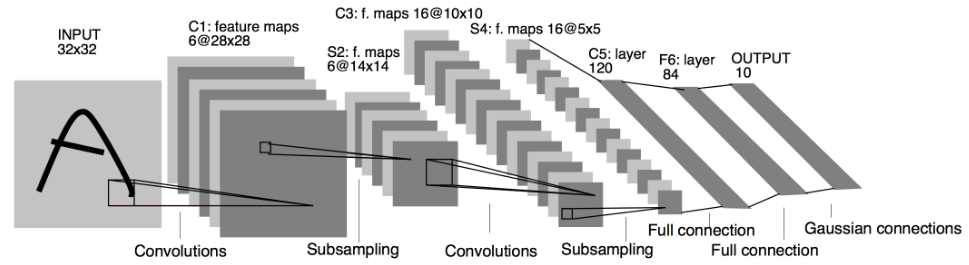

In [5]:
# LeNet5 structure
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        # 6 @ 28x28
        self.conv1 = nn.Sequential(
            # Lenet's first conv layer is 3x32x32, squeeze color channels into 1 and pad 2
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size =2, stride = 2)
        )
        # 16 @ 10x10
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size =5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size =2, stride = 2)
        )
    
        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.classifier = nn.Linear(84, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.classifier(x)
        return x
    

In [6]:
# Ensemble model
class LeNet5Ensemble(nn.Module):
    def __init__(self, num, num_classes, device):
        super(LeNet5Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList([LeNet5(num_classes).to(device) for _ in range(num)])
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), num_classes]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [7]:
# function which calculates accuracy
def accuracy(output, labels):
    pred = torch.argmax(output, dim=1)
    correct = pred.eq(labels)
    return torch.mean(correct.float())

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### One LeNet5 Model

In [9]:
# One LeNet5 network

model = LeNet5(num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,10000,15000], gamma=0.5)

total_loss, total_acc = 0,0
loss_list = []
acc_list = []

epochs = 10
itr = 1
p_itr = 1000

# start training
model.train()
for epoch in range(epochs):
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(output, labels)
        scheduler.step()
    
        if itr%p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_acc/p_itr))
            loss_list.append(total_loss/p_itr)
            acc_list.append(total_acc/p_itr)
            total_loss, total_acc = 0,0
        itr+=1
      

[Epoch 1/10] Iteration 1000 -> Train Loss: 0.7410, Accuracy: 0.721
[Epoch 2/10] Iteration 2000 -> Train Loss: 0.4563, Accuracy: 0.832
[Epoch 2/10] Iteration 3000 -> Train Loss: 0.3871, Accuracy: 0.859
[Epoch 3/10] Iteration 4000 -> Train Loss: 0.3515, Accuracy: 0.871
[Epoch 3/10] Iteration 5000 -> Train Loss: 0.3317, Accuracy: 0.878
[Epoch 4/10] Iteration 6000 -> Train Loss: 0.3015, Accuracy: 0.890
[Epoch 4/10] Iteration 7000 -> Train Loss: 0.2895, Accuracy: 0.893
[Epoch 5/10] Iteration 8000 -> Train Loss: 0.2820, Accuracy: 0.896
[Epoch 5/10] Iteration 9000 -> Train Loss: 0.2749, Accuracy: 0.898
[Epoch 6/10] Iteration 10000 -> Train Loss: 0.2652, Accuracy: 0.901
[Epoch 6/10] Iteration 11000 -> Train Loss: 0.2528, Accuracy: 0.906
[Epoch 7/10] Iteration 12000 -> Train Loss: 0.2471, Accuracy: 0.909
[Epoch 7/10] Iteration 13000 -> Train Loss: 0.2440, Accuracy: 0.909
[Epoch 8/10] Iteration 14000 -> Train Loss: 0.2388, Accuracy: 0.912
[Epoch 8/10] Iteration 15000 -> Train Loss: 0.2387, Accur

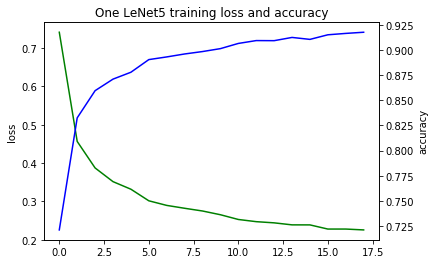

In [10]:
# plot training loss and accuracy

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='loss', color = 'g')
ax2.plot(acc_list, label='accuracy', color = 'b')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
plt.title('One LeNet5 training loss and accuracy')
plt.show()

In [11]:
# test 

model.eval()
test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)
        test_acc += accuracy(output, labels)

print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 10000 test images: 90.78%


### Ensemble model with 10 independent LeNet5 models

In [12]:
# Ten LeNet5 network
num_models = 10

ensemble_model = LeNet5Ensemble(num_models, num_classes, device)
ensemble_model = ensemble_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,10000,15000], gamma=0.5)

total_loss, total_acc = 0,0
loss_list = []
acc_list = []

epochs = 10
itr = 1
p_itr = 1000

# start training
ensemble_model.train()
for epoch in range(epochs):
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = ensemble_model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(output, labels)
        scheduler.step()
    
        if itr%p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_acc/p_itr))
            loss_list.append(total_loss/p_itr)
            acc_list.append(total_acc/p_itr)
            total_loss, total_acc = 0,0
        itr+=1
      


[Epoch 1/10] Iteration 1000 -> Train Loss: 0.5653, Accuracy: 0.790
[Epoch 2/10] Iteration 2000 -> Train Loss: 0.3530, Accuracy: 0.870
[Epoch 2/10] Iteration 3000 -> Train Loss: 0.3070, Accuracy: 0.887
[Epoch 3/10] Iteration 4000 -> Train Loss: 0.2860, Accuracy: 0.897
[Epoch 3/10] Iteration 5000 -> Train Loss: 0.2622, Accuracy: 0.904
[Epoch 4/10] Iteration 6000 -> Train Loss: 0.2272, Accuracy: 0.915
[Epoch 4/10] Iteration 7000 -> Train Loss: 0.2103, Accuracy: 0.923
[Epoch 5/10] Iteration 8000 -> Train Loss: 0.2045, Accuracy: 0.925
[Epoch 5/10] Iteration 9000 -> Train Loss: 0.1966, Accuracy: 0.926
[Epoch 6/10] Iteration 10000 -> Train Loss: 0.1813, Accuracy: 0.933
[Epoch 6/10] Iteration 11000 -> Train Loss: 0.1680, Accuracy: 0.939
[Epoch 7/10] Iteration 12000 -> Train Loss: 0.1537, Accuracy: 0.944
[Epoch 7/10] Iteration 13000 -> Train Loss: 0.1513, Accuracy: 0.944
[Epoch 8/10] Iteration 14000 -> Train Loss: 0.1435, Accuracy: 0.948
[Epoch 8/10] Iteration 15000 -> Train Loss: 0.1416, Accur

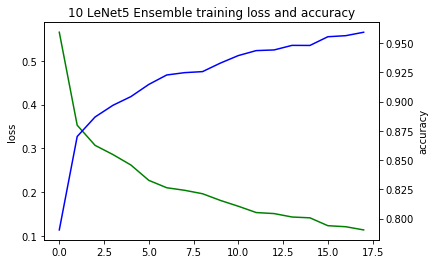

In [13]:
# plot training loss and accuracy

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='loss', color = 'g')
ax2.plot(acc_list, label='accuracy', color = 'b')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
plt.title('10 LeNet5 Ensemble training loss and accuracy')
plt.show()

In [14]:
# test 

ensemble_model.eval()
test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = ensemble_model(samples)
        test_acc += accuracy(output, labels)

print('Accuracy of the network on {} test images: {}%'.format(len(test_dataset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 10000 test images: 93.22%


## Conclusion
As you can see, it is just a simple version of ensemble.

But it shows higher accuracy ( bonus 2.4%p, from 90.78% -> 93.22% )

So it is worth you to try ensemble model !!

I always welcome all kinds of feedbacks.